In [1]:
import pickle

In [2]:
from PIL import  Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import layers

#import pickle5 as pickle

from sklearn.metrics import classification_report

In [3]:
skin_df = pd.read_csv("C:/Users/dhanu/Desktop/Project/Data/HAM10000_metadata.csv")
skin_df.head()
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


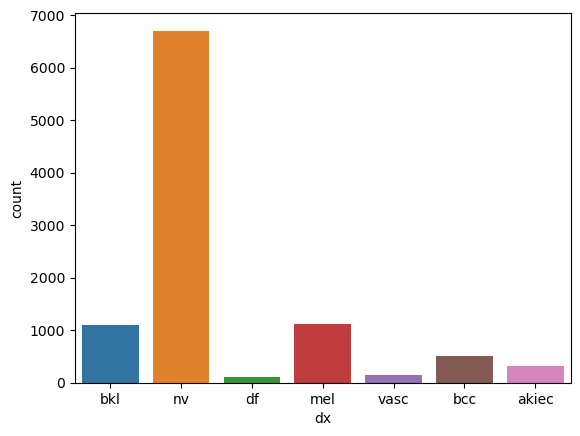

In [4]:
sns.countplot(x = "dx", data = skin_df)
plt.show()

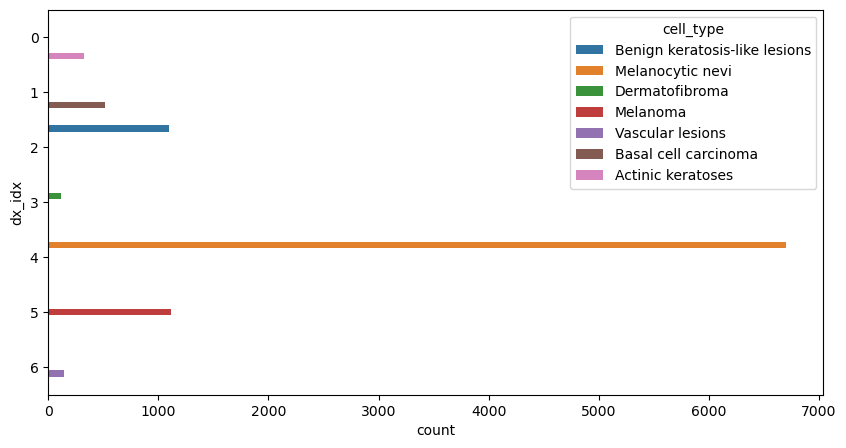

In [5]:
lesion_dict = {
                  'nv': 'Melanocytic nevi',
                  'mel': 'Melanoma',
                  'bkl': 'Benign keratosis-like lesions',
                  'bcc': 'Basal cell carcinoma',
                  'akiec': 'Actinic keratoses',
                  'vasc': 'Vascular lesions',
                  'df': 'Dermatofibroma'
              }

skin_df['cell_type'] = skin_df['dx'].map(lesion_dict.get)
skin_df['dx_idx'] = pd.Categorical(skin_df['cell_type']).codes

fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='dx_idx',data=skin_df, hue="cell_type",ax=ax1)
plt.show()

In [6]:
print('Total number of images =',len(skin_df))
print('Melanocytic nevus is unbalanced because it is much more common than other labels.')

show =skin_df['cell_type'].value_counts()
print(show)

Total number of images = 10015
Melanocytic nevus is unbalanced because it is much more common than other labels.
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


(128, 128, 3)
Shape one-hot encoding:  (10015, 7)
(8012, 128, 128, 3)
(8012, 7)
(2003, 128, 128, 3)
(2003, 7)
number of final training samples = 7210
number of test samples1 = 2003
X_train shape:(7210, 128, 128, 3)
Y_train shape:(7210, 7)
X_test shape: (2003, 128, 128, 3)
Y_test shape: (2003, 7)
X_val shape(802, 128, 128, 3)
Y_val shape(802, 7)


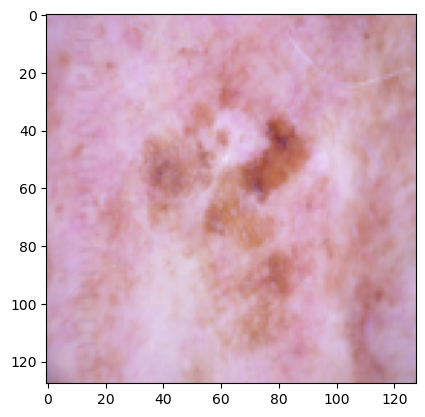

In [7]:
import pickle
skin_df=pickle.load( open ( "C:/Users/dhanu/Desktop/Project/Models/skin_dff.pkl",  "rb" ))
plt.imshow(skin_df["image"][0])
print(skin_df['image'][0].shape)


Y = to_categorical(skin_df["dx_idx"], num_classes = 7)
print("Shape one-hot encoding: ", Y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(skin_df,Y,test_size=0.20)
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

X_train,X_val, Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.10, random_state=42)

X_train  = X_train.reshape(X_train.shape[0],128,128,3)
X_test  = X_test.reshape(X_test.shape[0],128,128,3)
X_val  = X_val.reshape(X_val.shape[0],128,128,3)


print ("number of final training samples = " + str(X_train.shape[0]))
print ("number of test samples1 = " + str(X_test.shape[0]))
print ("X_train shape:" + str(X_train.shape))
print ("Y_train shape:" + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print("X_val shape" + str(X_val.shape))
print("Y_val shape" + str(Y_val.shape))

In [8]:
from keras.applications.vgg16 import VGG16, preprocess_input
pre_trained_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = True

print(len(pre_trained_model.layers))

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)# 0,5'lik bir bırakma oranı ekleyin
x = layers.Dense(7, activation='softmax')(x)
model = Model(pre_trained_model.input, x)

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

model.summary()

checkpoint = ModelCheckpoint('C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/checkpoint_vgg16.h5', monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max') #bu, en iyi dönemi kurtaran işlevdir

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=3)



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19
last layer output shape: (None, 4, 4, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 

In [9]:
epochs=20
batch_size=32

In [10]:
from tensorflow.keras.models import load_model

loaded_model = load_model("C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/checkpoint_vgg16.h5")

In [11]:
history = loaded_model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction,checkpoint])


#model.save("/content/drive/MyDrive/Project/Models/VGG16/Epoch1/VGG16_1.h5")

loaded_model.save('C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/vgg16.h5')

Epoch 1/20

225/225 [==============================] - ETA: 0s - loss: 0.2764 - acc: 0.9054
Epoch 1: val_acc improved from -inf to 0.92125, saving model to C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20\checkpoint_vgg16.h5


C:\Users\dhanu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 392s 2s/step - loss: 0.2764 - acc: 0.9054 - val_loss: 0.2083 - val_acc: 0.9212 - lr: 2.5000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.2586 - acc: 0.9086
Epoch 2: val_acc improved from 0.92125 to 0.93000, saving model to C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20\checkpoint_vgg16.h5
225/225 [==============================] - 393s 2s/step - loss: 0.2586 - acc: 0.9086 - val_loss: 0.1937 - val_acc: 0.9300 - lr: 2.5000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.2417 - acc: 0.9174
Epoch 3: val_acc did not improve from 0.93000
225/225 [==============================] - 392s 2s/step - loss: 0.2417 - acc: 0.9174 - val_loss: 0.2042 - val_acc: 0.9200 - lr: 2.5000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.2442 - acc: 0.9153
Epoch 4: val_acc did not improve from 0.93000
225/225 [==============================] - 389s 2s/step - loss: 0.2442 - acc: 0

In [12]:
scores=loaded_model.evaluate(X_test,Y_test)
print("Test success rate: {:.2f}".format(scores[1]*100))

scores=loaded_model.evaluate(X_val,Y_val)
print("Validation success rate: {:.2f}".format(scores[1]*100))

63/63 [==============================] - 88s 1s/step - loss: 0.2275 - acc: 0.9386
Test success rate: 93.86
26/26 [==============================] - 34s 1s/step - loss: 0.1762 - acc: 0.9327
Validation success rate: 93.27


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


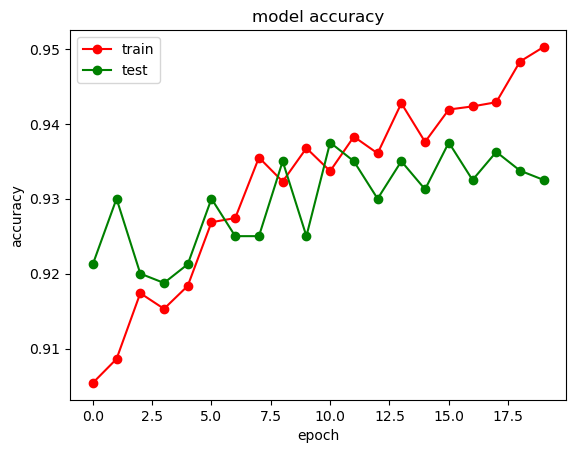

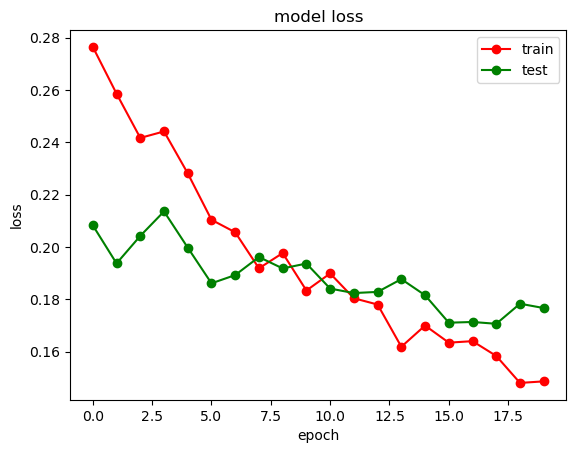

In [13]:
print(history.history.keys())

plt.plot(history.history['acc'] ,'ro-')
plt.plot(history.history['val_acc'] ,'go-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/acc_vgg.png',dpi=300)
plt.show()

plt.plot(history.history['loss'],'ro-')
plt.plot(history.history['val_loss'], 'go-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/loss_vgg.png',dpi=300)
plt.show()

63/63 [==============================] - 86s 1s/step


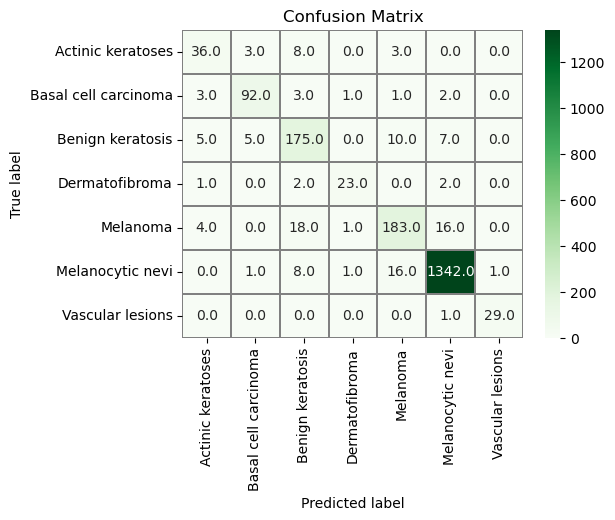

[[  36    3    8    0    3    0    0]
 [   3   92    3    1    1    2    0]
 [   5    5  175    0   10    7    0]
 [   1    0    2   23    0    2    0]
 [   4    0   18    1  183   16    0]
 [   0    1    8    1   16 1342    1]
 [   0    0    0    0    0    1   29]]


In [14]:
y_pred = loaded_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))


cm_df = pd.DataFrame(matrix,
                     index = ['Actinic keratoses','Basal cell carcinoma','Benign keratosis', 'Dermatofibroma','Melanoma','Melanocytic nevi','Vascular lesions'],
                     columns = ['Actinic keratoses','Basal cell carcinoma','Benign keratosis', 'Dermatofibroma','Melanoma','Melanocytic nevi','Vascular lesions'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",fmt= '.1f')
plt.title('Confusion Matrix');
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('C:/Users/dhanu/Desktop/Project/Models/VGG16/Epoch20/cm_vgg.png',dpi=300)
plt.show()


#y_pred = model.predict(X_test)
#  One-hot encoding the classes
y_pred_classes = np.argmax(y_pred, axis = 1)
# Gerçek etiketin çıkarılması
Y_true_classes = np.argmax(Y_test, axis = 1)
print(confusion_matrix(Y_true_classes, y_pred_classes))

In [15]:
y_pred = loaded_model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(Y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total test data:', total, '\t correct-predicted-data:', accurate, '\t incorrectly estimated data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

63/63 [==============================] - 86s 1s/step
Total test data: 2003 	 correct-predicted-data: 1880 	 incorrectly estimated data:  123
Accuracy: 93.859 %
